In [130]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [109]:
def setup_env():
    '''
    Arguments:
            None
    Returns:
            num_rows: number of rows in the gridworld
            num_columns: number of columns in the gridworld
            start_state: tuple containing the starting state of the agent
            goal_state: final goal 
            cliff: array containing the cliff states
            states: array containing all states of the gridworld
    '''
    num_rows = 4
    num_columns = 12
    start_state = (3,0)
    goal_state = (3,11)
    cliff = [(3,1),(3,2),(3,3),(3,4),(3,5),(3,6),(3,7),(3,8),(3,9),(3,10)]
    states = []
    for row in range(num_rows):
        for col in range(num_columns):
            states.append((row,col))
    
    return num_rows,num_columns,start_state,goal_state,cliff,states

In [3]:
# Make the necessary move 

def make_move(current_position,move,goal_state,cliff):
    '''
    Arguments: 
            current_position: tuple containing the current position of the agent
            move: 'l','r','u' or 'd'
            goal_state: tuple containing the final state
            cliff: array containing the cliff states
    Returns:
            new_position: tuple containing the new position of the agent after the move is made
            reward: reward assigned to the move made at the state depending on the next state reached
    '''
    
    # Convert tuple to list so the operations are easier
    current_position = list(current_position)
    new_position = current_position
    
    # While making a move, it must be ensured that the agent doesn't go out of the environment
    if move == 'l':
        new_position[1] = max(0,current_position[1] - 1)
    elif move == 'r':
        new_position[1] = min(11,current_position[1] + 1)
    elif move == 'u':
        new_position[0] = max(0,current_position[0] - 1)
    elif move == 'd':
        new_position[0] = min(3,current_position[0] + 1)
        
    new_position = tuple(new_position)
    reward = -1
    
    if new_position in cliff:
        new_position = (3,0)
        reward = -100
    elif new_position == goal_state:
        reward = 0
    else:
        reward = -1
    
    return new_position,reward


In [4]:
# Find the best action

def best_action(Q,state):
    '''
    Arguments:
            Q: The state-action value function
            state: current state of the agent
    Returns:
            max_action: The optimal action in the state
    '''
    val = -1e17
    max_action = 'l'
    # Iterate through all state action-pairs for the state and find the best one
    for action,value in Q[state].items():
        if value > val:
            val = value
            max_action = action
    
    return max_action


# Find an action using epsilon-greedy policy

def get_action(Q,state,epsilon):
    '''
    Arguments:
            Q: The state-action value function
            state: current state of the agent
    Returns:
            action: action picked by the epsilon-greedy policy
    '''
    val = np.random.rand()
    action = ''
    # if val > epsilon, choose the best action, else choose a random action
    if val > epsilon:
        action = best_action(Q,state)
    else:
        list_actions = get_possible_actions(state)
        action = random.choice(list_actions)

    return action

In [5]:
# Find the list of possible action in a state

def get_possible_actions(state):
    '''
    Arguments:
            state: one of the states of the gridworld
    Returns:
            actions: list of possible actions from the given state
    '''
    actions = []
    if state[0] > 0:
        actions.append('u')
    if state[0] < 3:
        actions.append('d')
    if state[1] > 0:
        actions.append('l')
    if state[1] < 11:
        actions.append('r')
    
    return actions

In [149]:
# Implementation of sarsa

def sarsa(states,goal_state,start_state,cliff,alpha,epsilon,gamma = 1,episodes=1000):
    '''
    Arguments:
            states: array of states in the gridworld
            goal_state: tuple containing the goal state
            start_state: tuple containing the start state
            wind: array containing the wind strengths of different columns
            alpha: step-size parameter
            gamma: discount factor(1 here as the task is undiscounted)
            episodes: number of episodes for training
    Returns:
            Q: state-action value function after sarsa is finished
    '''
    # Initialize the state-action value function
    Q = {}
    for state in states:
        Q[state] = {}
        possible_actions = get_possible_actions(state)
        for action in possible_actions:
            Q[state][action] = 0
    
    rewards = []
    # Iterate for required number of episodes
    for episode in range(1,episodes+1):
        # Initialize current state and action
        current_state = start_state
        current_action = get_action(Q,current_state,epsilon)
        # Variable to calculate reward in an episode
        r = 0
        # Loop until goal is not reached
        while current_state != goal_state:
            
            next_state,reward = make_move(current_state,current_action,goal_state,cliff)
            next_action = get_action(Q,next_state,epsilon)       # Find next action based on epsilon-greedy policy
            r += reward
            # Sarsa update
            Q[current_state][current_action] = Q[current_state][current_action] + alpha*(reward + gamma*Q[next_state][next_action] - Q[current_state][current_action])
            
            current_state = next_state
            current_action = next_action
            if current_state == goal_state:
                break
        rewards.append(r)
    return Q,rewards

In [143]:
# Implementation of Q learning

def Q_learning(states,goal_state,start_state,cliff,alpha = 0.1,epsilon = 0.1,gamma = 1,episodes=1000):
    '''
    Arguments:
            states: array of states in the gridworld
            goal_state: tuple containing the goal state
            start_state: tuple containing the start state
            wind: array containing the wind strengths of different columns
            alpha: step-size parameter
            gamma: discount factor(1 here as the task is undiscounted)
            episodes: number of episodes for training
    Returns:
            Q: state-action value function after Q learning is finished
    '''
    # Initialize the state-action value function
    Q = {}
    for state in states:
        Q[state] = {}
        possible_actions = get_possible_actions(state)
        for action in possible_actions:
            Q[state][action] = 0
    rewards = []
    # Iterate for required number of episodes
    for episode in range(1,episodes+1):
        # Initialize current state and action
        current_state = start_state
        current_action = get_action(Q,current_state,epsilon/episode)
        
        # Variable to calculate reward in an episode
        r = 0
        # Loop until goal is not reached
        while current_state != goal_state:
            
            next_state,reward = make_move(current_state,current_action,goal_state,cliff)
            next_action = best_action(Q,next_state)       # Find next action based on greedy policy
            r += reward
            
            # Q Learning update
            Q[current_state][current_action] = Q[current_state][current_action] + alpha*(reward + gamma*Q[next_state][next_action] - Q[current_state][current_action])
            
            current_state = next_state
            current_action = next_action
            if current_state == goal_state:
                break
        
        rewards.append(r)
    return Q,rewards

In [144]:
# Optimal policy 

def optimal_policy(Q,states,goal_state,start_state,cliff,num_rows,num_columns):
    '''
    Arguments:
            Q: state-action value function after sarsa is completed
            states: array of states in the gridworld
            goal_state: tuple containing the goal state
            start_state: tuple containing the start state
            wind: array containing the wind strengths of different columns
            num_rows: number of rows in the gridworld
            num_columns: number of columns in the gridworld
    Returns:
            visiting: array containing the steps taken in optimal path
            returns: return when optimal path is followed
            path: array containing the optimal path
            
    '''
    current_state = start_state
    path = []
    path.append(current_state)
    visiting = np.zeros((num_rows,num_columns))
    steps = 2
    returns = 0
    # Follow greedy policy from start state until goal is reached
    while 1:
        action = best_action(Q,current_state)
        next_state,r = make_move(current_state,action,goal_state,cliff)
        returns += r
        visiting[next_state[0]][next_state[1]] = steps
        current_state = next_state
        steps += 1
        path.append(current_state)
        if current_state == goal_state:
            break
    visiting[start_state[0]][start_state[1]] = 1
            
    return visiting,returns,path

In [145]:
def print_results(num_rows,num_columns,visiting,reward,path):
    '''
    Arguments:
            num_rows: number of rows in the environment
            num_columns: number of columns in the environment
            visiting: array denoting the states visited in the optimal path
            reward: reward in the optimal path
            path: optimal path followed by the agent
    '''
    print("The optimal path is:")
    path = '->'.join([str(item) for item in path])
    print(path,'\n')
    print('The path taken can be visualized as:')
    for i in range(num_rows):
        for j in range(num_columns):
            print('{:1.0f}'.format(visiting[i][j]), end="\t")
        print()
    print(f'\nThe optimal return is {reward}')

In [239]:
# Function to implement sarsa learning

def implement_sarsa():
    '''
    Arguments: None
    Returns:
            rewards: array containing rewards in all the episodes
    '''
    # Define env
    num_rows,num_columns,start_state,goal_state,cliff,states = setup_env()
    # Find state action value function
    Q,rewards = sarsa(states,goal_state,start_state,cliff,alpha = 0.1,epsilon = 0.2,gamma = 1,episodes = 8000)
    
    # Find optimal path
    visiting,reward,path = optimal_policy(Q,states,goal_state,start_state,cliff,num_rows,num_columns)
    print_results(num_rows,num_columns,visiting,reward,path)
    return rewards


In [240]:
def implement_Q():
    '''
    Arguments: None
    Returns:
            rewards: array containing rewards in all the episodes
    '''
    # Define env
    num_rows,num_columns,start_state,goal_state,cliff,states = setup_env()
    # Find state action value function
    Q,rewards = Q_learning(states,goal_state,start_state,cliff,alpha = 0.5,epsilon = 0.1,gamma = 1,episodes = 2000)
    
    # Find optimal path
    visiting,reward,path = optimal_policy(Q,states,goal_state,start_state,cliff,num_rows,num_columns)
    print_results(num_rows,num_columns,visiting,reward,path)
    return rewards


The optimal path is:
(3, 0)->(2, 0)->(1, 0)->(0, 0)->(0, 1)->(0, 2)->(0, 3)->(0, 4)->(0, 5)->(0, 6)->(0, 7)->(0, 8)->(0, 9)->(0, 10)->(0, 11)->(1, 11)->(2, 11)->(3, 11) 

The path taken can be visualized as:
4	5	6	7	8	9	10	11	12	13	14	15	
3	0	0	0	0	0	0	0	0	0	0	16	
2	0	0	0	0	0	0	0	0	0	0	17	
1	0	0	0	0	0	0	0	0	0	0	18	

The optimal return is -16


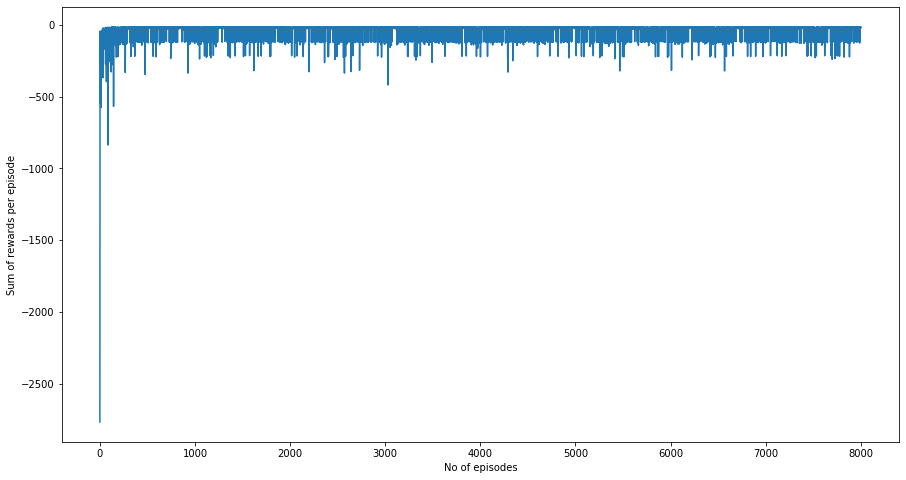

In [241]:
sarsa_rewards = implement_sarsa()
# print_results()
plt.figure(figsize=(15,8))
plt.plot(sarsa_rewards)
plt.xlabel('No of episodes')
plt.ylabel('Sum of rewards per episode')
plt.show()

The optimal path is:
(3, 0)->(2, 0)->(2, 1)->(2, 2)->(2, 3)->(2, 4)->(2, 5)->(2, 6)->(2, 7)->(2, 8)->(2, 9)->(2, 10)->(2, 11)->(3, 11) 

The path taken can be visualized as:
0	0	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	0	
2	3	4	5	6	7	8	9	10	11	12	13	
1	0	0	0	0	0	0	0	0	0	0	14	

The optimal return is -12


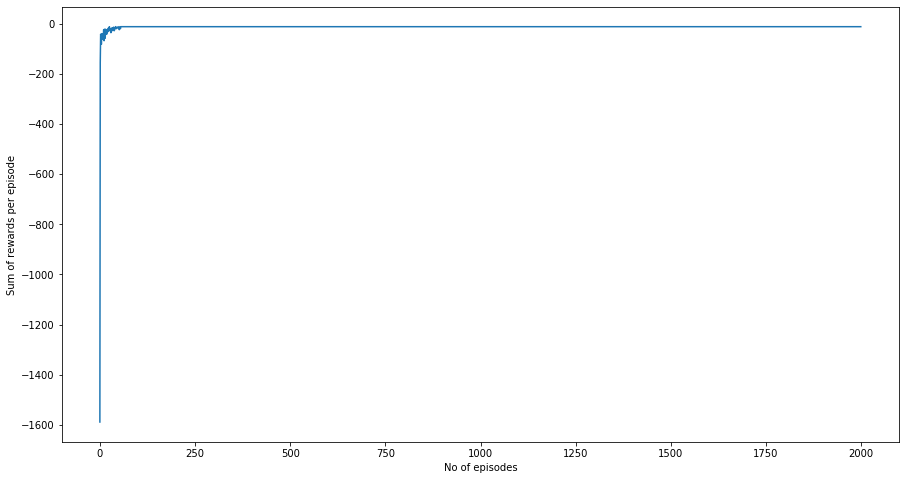

In [242]:
Q_rewards = implement_Q()
plt.figure(figsize=(15,8))
plt.plot(Q_rewards)
plt.xlabel('No of episodes')
plt.ylabel('Sum of rewards per episode')
plt.show()